In [1]:
import pandas as pd
import os

In [2]:
os.getcwd()

'/home/tudor/cave/drug_reviews/notebooks'

In [3]:
data = pd.read_csv(r"../data/raw/drugsComTrain_raw.tsv", sep="\t").drop("Unnamed: 0", axis=1)
test = pd.read_csv(r"../data/raw/drugsComTest_raw.tsv", sep="\t").drop("Unnamed: 0", axis=1)

In [4]:
data['review'] = data['review'].str.replace('&#039;',"'",)
data['review'] = data['review'].str.replace('"',"")

In [5]:
test['review'] = test['review'].str.replace('&#039;',"'",)
test['review'] = test['review'].str.replace('"',"")

In [6]:
data = data[data['condition'].str.contains("users found this comment helpful") == False]
test = test[test['condition'].str.contains("users found this comment helpful") == False]

In [7]:
data.to_csv("../data/raw/drugs_train.csv", index=False)
test.to_csv("../data/raw/drugs_test.csv", index=False)

# ML

In [20]:
import time
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score



<AxesSubplot:>

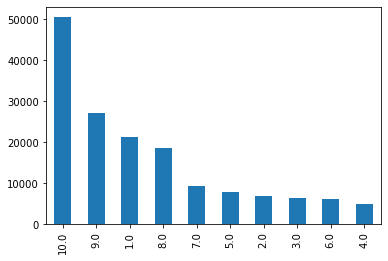

In [21]:
data_["rating"].value_counts().plot.bar()

In [22]:
x = data_['review']
y = data_['rating']

In [25]:
# Feature extractors.
feature_extractors = [
CountVectorizer(),
TfidfVectorizer(),
# Ignore words that appear in less than 20% of posts (rare words).
CountVectorizer(min_df=0.2),
# Ignore words that appear in more than 80% of posts (frequent words).
CountVectorizer(max_df=0.8),
CountVectorizer(ngram_range=(2, 2)),
CountVectorizer(ngram_range=(3, 3)),
TfidfVectorizer(min_df=0.2),
TfidfVectorizer(max_df=0.8),
TfidfVectorizer(ngram_range=(2, 2)),
TfidfVectorizer(ngram_range=(3, 3))
]

# Classifiers.
classifiers = [ 
# LinearSVC(max_iter=100000), 
# LogisticRegression(max_iter=100000),
KNeighborsClassifier(n_jobs=-1),
RandomForestClassifier(n_jobs=-1),
DecisionTreeClassifier()
]

In [26]:
cv = StratifiedKFold(n_splits=5)

scoring = {
'f1_score': make_scorer(f1_score, average='weighted')
}

In [27]:
def start_ML_pipeline():
   for classifier in classifiers:
      for extractor in feature_extractors:
         start_time = time.time()
         pipeline = Pipeline([('extractor', extractor), ('classifier', classifier)])
         scores = cross_validate(pipeline, x, y, cv=cv, scoring=scoring)
         end_time = time.time()
         total_time = round((end_time - start_time)/60, 2)
         
         f1_score = round(np.mean(scores['test_f1_score']), 2)
         # precision = round(np.mean(scores['test_precision']), 2)
         # recall = round(np.mean(scores['test_recall']), 2)
         # acc = round(np.mean(scores['test_accuracy']), 2)

         print("Time: ", total_time, " min")
         print("Experiment: ", str(classifier), "+", str(extractor))
         print("F1 score= ", f1_score, ", 5-fold CV=", scores['test_f1_score'])
         # print("Precision= ", precision, ", 5-fold CV=", scores['test_precision'])
         # print("Recall= ", recall, ", 5-fold CV=", scores['test_recall'])
         # print("Accuracy= ", acc, ", 5-fold CV=", scores['test_accuracy'])
         print("="*100)

In [ ]:
start_ML_pipeline()

# DL

In [24]:
data  = pd.read_csv(r"../data/drugs_test.csv")

In [25]:
data['review'][0]

"I've tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I've actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."

In [26]:
len(data)

53200

In [10]:
import os
from typing import Optional
import pandas as pd
import pretty_errors
import torch
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import RobertaTokenizerFast
from transformers.models.auto.tokenization_auto import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
from pytorch_lightning import LightningModule
from torch.nn import Dropout, Linear, Module, ReLU, Sequential, Sigmoid
from torch.nn.modules.loss import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.functional import f1
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from torch.nn.functional import sigmoid, one_hot
import logging as log
import os
import warnings

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import logging


In [17]:
class BaseDataset(Dataset):
    def __init__(
        self,
        model_name: str = None,
        data_frame: str = None,
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.data = data_frame

    def __getitem__(self, idx):
        text = self.data['review'][idx]
        label = self.data['rating'][idx]
        text = self.tokenizer.encode_plus(
            text,
            # add_special_tokens=True,
            max_length=512,
            padding="max_length",
            # return_tensors="pt",
            return_attention_mask=True,
            truncation=True,
        )
        return {
            "ids": torch.tensor(text["input_ids"], dtype=torch.long),
            "mask": torch.tensor(text["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(int(label), dtype=torch.long),
        }

    def __len__(self):
        return len(self.data)


In [18]:
class DataModule(LightningDataModule):
    def __init__(
        self,
        num_workers: int = 8,
        batch_size: int = 2,
        model_name: str = None,
        data_path: str = None,
    ):
        super().__init__()

        self.num_workers = num_workers
        self.batch_size = batch_size
        self.model_name = model_name
        self.data = pd.read_csv(data_path)
        self.train, self.val = None, None

    def setup(self, stage: Optional[str] = None) -> None:
        self.train, self.val = train_test_split(self.data, test_size=0.2, stratify=self.data['rating'])

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            BaseDataset(data_frame=self.train.reset_index(drop=True), model_name=self.model_name),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            BaseDataset(data_frame=self.val.reset_index(drop=True), model_name=self.model_name),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )



In [19]:
class BaseBert(LightningModule):
    def __init__(self, model=None, n_classes: int = None) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.lr = 0.003
        self.bert = AutoModelForSequenceClassification.from_pretrained(model, num_labels=n_classes)
        # print(self.bert)
        self.criterion = CrossEntropyLoss()
        self.freeze_model(self.bert.bert)

    def freeze_model(self, model):
        for param in model.parameters():
            param.requires_grad = False

    def forward(self, ids, mask):
        out = self.bert(input_ids=ids, attention_mask=mask)
        # out = torch.sigmoid(out)
        return out

    def configure_optimizers(self):
        optimizer = Adam(self.bert.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer
        }

    def training_step(self, batch, _):
        ids, mask, labels = batch["ids"], batch["mask"], batch["labels"]
        output = self(ids, mask)
        output = output[0]
        # output = torch.argmax(output, dim=1)
        print(output)
        loss = self.criterion(output, labels)
        self.log("train/loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    # def validation_step(self, batch, _):
    #     ids, mask, labels = batch["ids"], batch["mask"], batch["labels"]
    #     output = self(ids, mask, labels)
    #     print(output)
    #     loss = output['loss']
    #     logits = output['logits']
    #     # loss = self.criterion(output, labels)
    #     f1_score = f1(sigmoid(logits), labels.int(), average="macro", num_classes=self.n_classes)
    #     return {"loss": loss, "f1": f1_score}

    # def validation_epoch_end(self, out):
    #     loss = torch.stack([x["loss"] for x in out]).mean()
    #     f1_score = torch.stack([x["f1"] for x in out]).mean()
    #     self.log("val/val_loss", loss, on_epoch=True, on_step=False)
    #     self.log("val/val_f1", f1_score, on_epoch=True, on_step=False)

In [20]:
MODEL='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
data = DataModule(data_path=r'../data/drugs_train.csv', model_name=MODEL)

model = BaseBert(model=MODEL, n_classes=10)
trainer = Trainer(
        gpus=1,
        max_epochs=1,
    )
trainer.fit(model, datamodule=data)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

Epoch 0:   0%|          | 0/63799 [00:00<?, ?it/s]tensor([[-0.0667,  0.2759, -0.4193, -0.9708, -0.4728, -0.1505,  0.0562, -0.3366,
          0.0655, -0.0272],
        [-0.0670,  0.5937, -0.1746, -0.7611, -0.3530, -0.0722, -0.0641, -0.6967,
         -0.0078, -0.3326]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 0:   0%|          | 1/63799 [00:00<5:24:06,  3.28it/s, loss=2.21, v_num=0]tensor([[-0.7518, -0.2709, -0.8620, -1.1923, -1.0401, -0.7716,  0.4327, -0.8111,
         -0.5590,  0.2603],
        [-0.6685, -0.2183, -0.8289, -1.3225, -0.9243, -0.5310,  0.5743, -0.8304,
         -0.4321,  0.2908]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 0:   0%|          | 2/63799 [00:00<3:01:50,  5.85it/s, loss=2.54, v_num=0]tensor([[-1.1922, -1.0044, -1.4399, -1.2035, -1.6453, -1.4159,  0.7040, -1.4549,
         -0.3291,  0.5455],
        [-1.3951, -0.9573, -1.6025, -1.1967, -1.8127, -1.3657,  0.6847, -1.8685,
         -0.3991,  0.4052]], device='cuda:0', grad_fn=<AddmmBackward0>)


/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.


Epoch 0:   0%|          | 0/63799 [00:34<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.